In [53]:
using DifferentialEquations, Plots, StatsPlots
using CSV, DataFrames
using Turing, MCMCChains
using Interpolations


In [54]:
t = vec(0.01:0.01:9.99)

function twoSpringMass!(du, u, p, t)

# Unzip the parameters
x1, x1dot, x2, x2dot = u
k1, k2, k3, c1, c2, c3, m1, m2 = p

# Define the ODE
du[1] = x1dot
du[2] = -(k1+k2)/m1*x1 -(c1+c2)/m1*x1dot +k2/m1*x2 + c2/m1*x2dot + 2/m1
du[3] = x2dot
du[4] = k2/m2*x1 + c2/m2*x1dot - (k2+k3)/m2*x2 - (c2+c3)/m2*x2dot

end

twoSpringMass! (generic function with 1 method)

In [55]:
sys_data = CSV.read("testData.txt", DataFrame; delim = ',')

999×7 DataFrame
 Row │ 0        2      0_1          0_2          0_3          0_4           0. ⋯
     │ Float64  Int64  Float64      Float64      Float64      Float64       Fl ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    0.01      2  0.000135716   0.0271365   1.76277e-7    5.49214e-5      ⋯
   2 │    0.02      2  0.000542562   0.0542228   1.57266e-6    0.000252078
   3 │    0.03      2  0.00121994    0.0812398   5.85147e-6    0.000639282
   4 │    0.04      2  0.00216706    0.108169    1.51473e-5    0.00126314
   5 │    0.05      2  0.00338296    0.13499     3.20541e-5    0.00216887      ⋯
   6 │    0.06      2  0.00486645    0.161687    5.96098e-5    0.00340007
   7 │    0.07      2  0.00661621    0.188239    0.00010128    0.00499857
   8 │    0.08      2  0.00863069    0.21463     0.000160939   0.00700422
   9 │    0.09      2  0.0109082     0.240841    0.000242848   0.00945475      ⋯
  10 │    0.1       2  0.0134469     0.266856    0.000351635   0.0123856
  11 │    0.11      2  0.0162446     0.292657    0.000492271   0.0158297
  ⋮  │    ⋮       ⋮         ⋮            ⋮            ⋮            ⋮           ⋱
 990 │    9.9       2  0.88577      -0.0237369   0.460183     -0.0123
 991 │    9.91      2  0.885442     -0.0418424   0.460007     -0.0230082       ⋯
 992 │    9.92      2  0.884933     -0.0599143   0.459723     -0.0337026
 993 │    9.93      2  0.884244     -0.0779441   0.459333     -0.0443762
 994 │    9.94      2  0.883374     -0.095923    0.458836     -0.0550217
 995 │    9.95      2  0.882325     -0.113842    0.458233     -0.0656322       ⋯
 996 │    9.96      2  0.881098     -0.131694    0.457523     -0.0762006
 997 │    9.97      2  0.879692     -0.149469    0.456709     -0.0867198
 998 │    9.98      2  0.878109     -0.167158    0.455789     -0.097183
 999 │    9.99      2  0.876349     -0.184754    0.454765     -0.107583        ⋯
                                                   1 column and 978 rows omitted

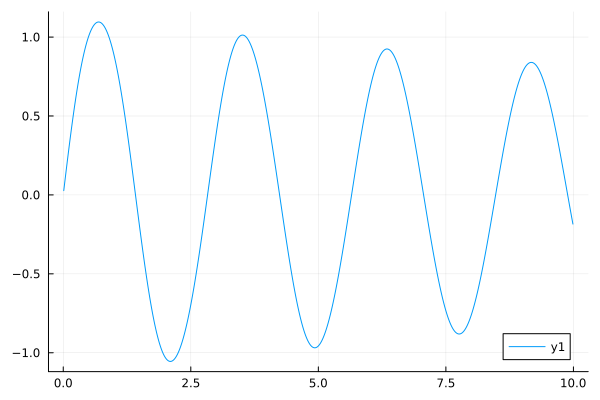

In [56]:
dataArray = Array(sys_data);
plot(t,sys_data[:,4])

In [57]:
@model function fitTwoSpringMass(data)
    sigma ~ InverseGamma(2,3)

    k1 ~ truncated(Normal(2.5, 1.25),0.5,5)
    k2 ~ truncated(Normal(2.5, 1.25),0.5,5)
    k3 ~ truncated(Normal(2.5, 1.25),0.5,5)

    c1 ~ truncated(Normal(0.05, 0.025),0.005,0.0995)
    c2 ~ truncated(Normal(0.05, 0.025),0.005,0.0995)
    c3 ~ truncated(Normal(0.05, 0.025),0.005,0.0995)

    m1 ~ truncated(Normal(0.5, 0.4),0.1,0.9)
    m2 ~ truncated(Normal(0.5, 0.4),0.1,0.9)

    param = [k1, k2, k3, c1, c2, c3, m1, m2]
    prob = ODEProblem(twoSpringMass!, [0, 0, 0, 0], (0.0, 2), param)
    predicted = solve(prob, Tsit5(), saveat=2)

    for i in 1:length(predicted)
        data[1, i] ~ Normal(predicted[1,i], sigma)
        data[2, i] ~ Normal(predicted[2,i], sigma)
        data[3, i] ~ Normal(predicted[3,i], sigma)
        data[4, i] ~ Normal(predicted[4,i], sigma)
    end
end

fitTwoSpringMass (generic function with 2 methods)

In [ ]:
model = fitTwoSpringMass(dataArray[1:10:990,3:6])
posterior = sample(model,NUTS(0.5),10000)


┌ Info: Found initial step size
└   ϵ = 0.8
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:30


Chains MCMC chain (10000×21×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 33.38 seconds
Compute duration  = 33.38 seconds
parameters        = sigma, k1, k2, k3, c1, c2, c3, m1, m2
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

       sigma    0.5648    0.2169    0.0090    388.3734    530.8003    1.0011   ⋯
          k1    3.2480    0.9287    0.0275   1145.0652   1210.6349    1.0006   ⋯
          k2    2.6109    0.9941    0.0306   1083.0541    920.0744    1.0005   ⋯
          k3    2.8389    1.0656    0.0372    860.4393   1243.3116    1.0002   ⋯
          c1    0.0509    0.021

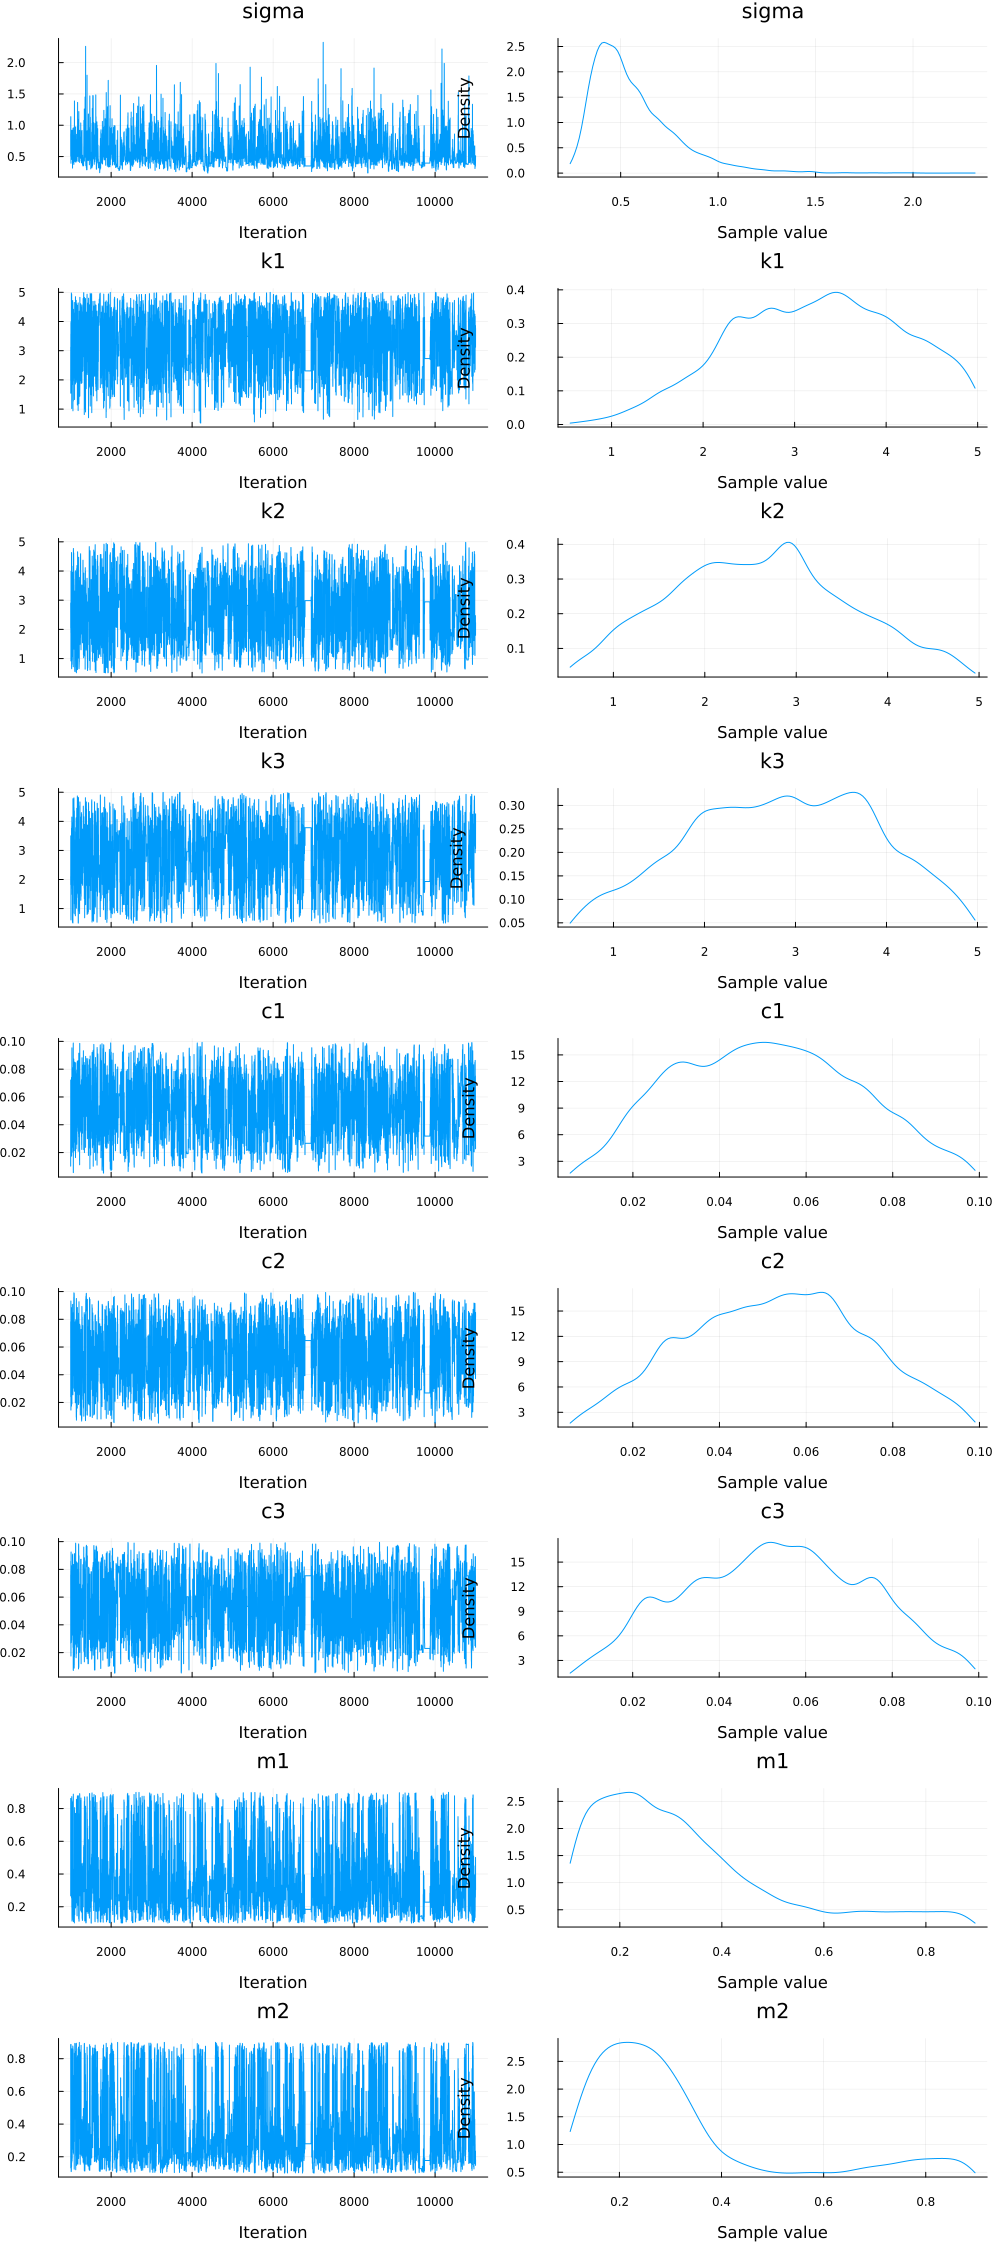

In [59]:
plot(posterior)

In [ ]:
 = sample(posterior[:bx], 100)
 = sample(posterior[:mx], 100)
 = sample(posterior[:by], 100)
 = sample(posterior[:my], 100)